In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
import numpy as np
import pandas as pd
import scipy.stats

import matplotlib
import matplotlib.pyplot as plt
import colorcet
import seaborn as sns


import sklearn.metrics
import sklearn.neural_network
import sklearn.neighbors
import skimage.filters

In [4]:
from wassersteinwormhole import Wormhole

2024-03-28 10:16:09.395952: W external/xla/xla/service/platform_util.cc:198] unable to create StreamExecutor for CUDA:0: failed initializing StreamExecutor for CUDA device ordinal 0: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_DEVICE_UNAVAILABLE: CUDA-capable device(s) is/are busy or unavailable
CUDA backend failed to initialize: INTERNAL: no supported devices found for platform CUDA (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


# Load MNIST data

In [5]:
import tensorflow.keras.datasets
mnist = tensorflow.keras.datasets.mnist

(image_train, label_train), (image_test, label_test) = mnist.load_data()

2024-03-24 13:31:40.580696: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
thresh = skimage.filters.threshold_otsu(image_train.reshape([-1]))

In [7]:
pc_train = [np.stack(np.where(image>thresh), axis = 1) for image in image_train]
pc_test = [np.stack(np.where(image>thresh), axis = 1) for image in image_test]


## Show some examples

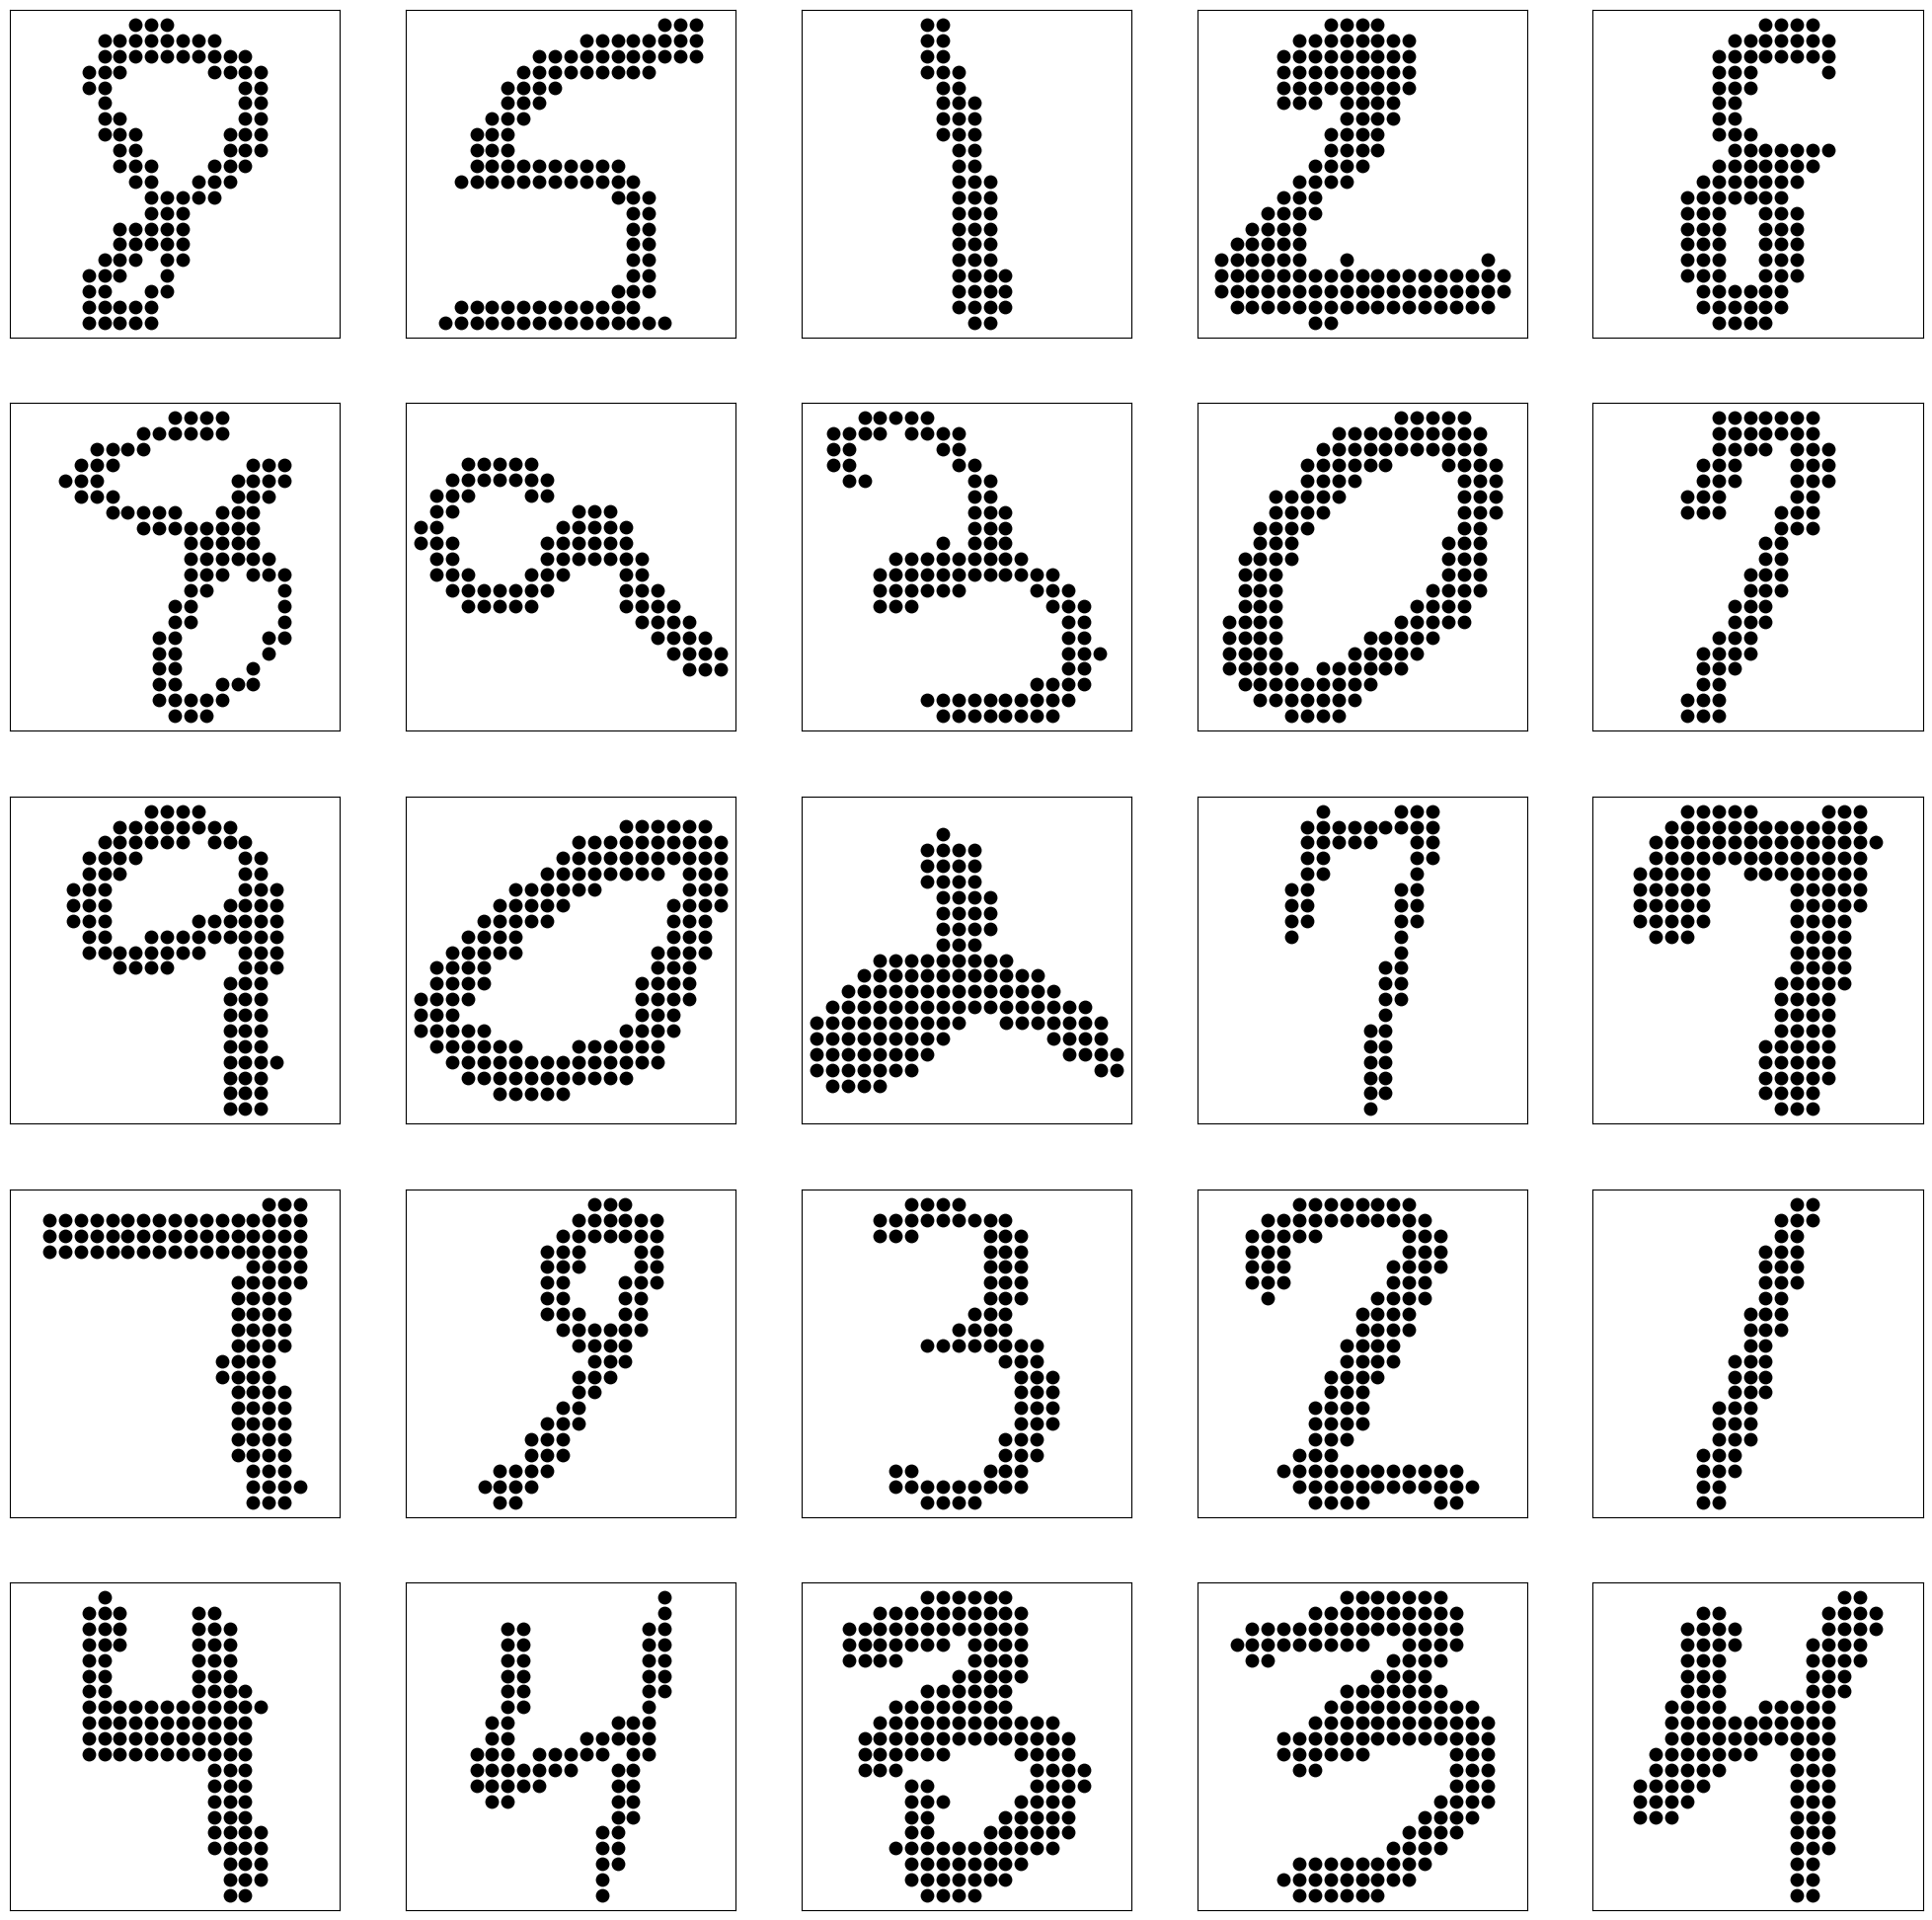

In [8]:
fig = plt.figure(figsize = (25,25))
for _ in range(25):
    ind = np.random.choice(np.arange(len(pc_train)))
    plt.subplot(5,5,1+_)
    plt.scatter(pc_train[ind][:, 1], -pc_train[ind][:, 0], c = 'black', s = 80)
    plt.xticks([])
    plt.yticks([])
    plt.axis('equal')
plt.show()

# Batch size Ablation

Run Wormhole with different batch sizes to see how it impacts training curves

In [7]:
sizes = [2, 4, 8, 16, 32, 64]

In [18]:
dec_loss = []
enc_loss = []

In [ ]:
for size in sizes:
    WormholeModel = Wormhole(point_clouds = pc_train, point_clouds_test = pc_test)
    WormholeModel.train(batch_size = size, compute_test = True)
    
    dec_loss.append(WormholeModel.dec_loss_test)
    enc_loss.append(WormholeModel.enc_loss_test)
    
dec_loss = np.asarray(dec_loss)
enc_loss = np.asarray(enc_loss)

Using Calculated Min Max Scaling Values


 enc_loss: 5.428e-05 dec_loss: 2.483e-03 enc_corr: nan: 100%|██████████| 10000/10000 [20:05<00:00,  8.29it/s]


Using Calculated Min Max Scaling Values


 enc_loss: 3.355e-05 dec_loss: 1.592e-03 enc_corr: 0.963: 100%|██████████| 10000/10000 [20:55<00:00,  7.96it/s]


Using Calculated Min Max Scaling Values


 enc_loss: 3.013e-05 dec_loss: 1.338e-03 enc_corr: 0.985: 100%|██████████| 10000/10000 [22:22<00:00,  7.45it/s]


Using Calculated Min Max Scaling Values


 enc_loss: 3.298e-05 dec_loss: 1.014e-03 enc_corr: 0.983: 100%|██████████| 10000/10000 [24:08<00:00,  6.90it/s]


Using Calculated Min Max Scaling Values


 enc_loss: 2.587e-05 dec_loss: 7.836e-04 enc_corr: 0.987: 100%|██████████| 10000/10000 [35:12<00:00,  4.73it/s]


Using Calculated Min Max Scaling Values


 enc_loss: 3.324e-05 dec_loss: 1.463e-03 enc_corr: 0.985:  48%|████▊     | 4814/10000 [40:10<42:39,  2.03it/s]  

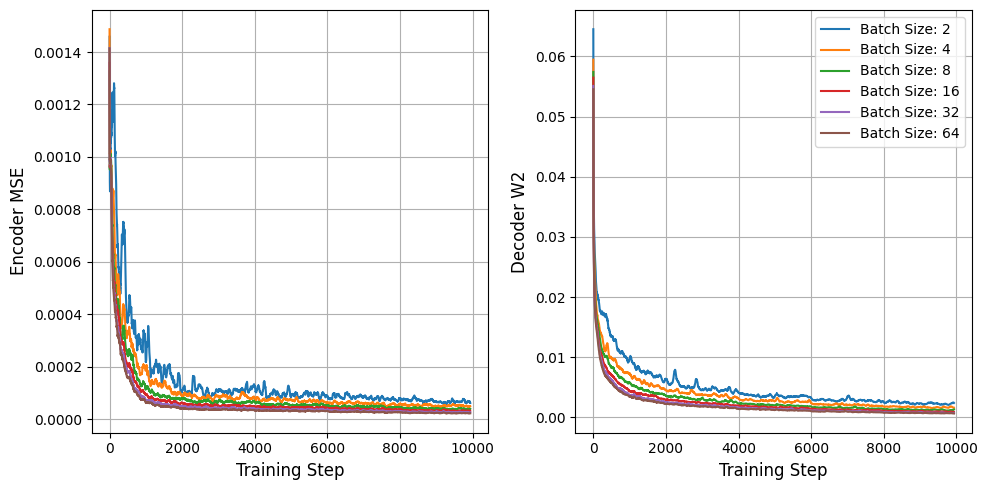

In [9]:
smooth = 64

plt.figure(figsize=(10,5))

plt.subplot(121)
for ind, size in enumerate(sizes):
    plt.plot(np.convolve(enc_loss[ind], np.ones(smooth)/64, mode = 'valid'), label = f'Batch Size: {size}')
plt.ylabel('Encoder MSE', fontdict={'size': 12})
plt.xlabel('Training Step', fontdict={'size': 12})
plt.grid()

plt.subplot(122)
for ind, size in enumerate(sizes):
    plt.plot(np.convolve(dec_loss[ind], np.ones(64)/64, mode = 'valid'), label = f'Batch Size: {size}')
plt.legend()
plt.ylabel('Decoder W2', fontdict={'size': 12})
plt.xlabel('Training Step', fontdict={'size': 12})
plt.tight_layout()
plt.grid()
plt.show()